##### Copyright 2019 The TensorFlow Authors.

Copied from the original cnn.ipynb. Modified to split the 3 RGB channels into 4, CMYK.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Network (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import keras_tuner
import matplotlib.pyplot as plt
import numpy as np

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [3]:
#first see if the train and test images are already created - speeds up additional runs

(train_images_orig, train_labels), (test_images_orig, test_labels) = datasets.cifar10.load_data()

try:
    train_images = np.load('train_images_cymk.npy')
    test_images = np.load('test_images_cymk.npy')
except:
    train_images = None
    test_images = None

if train_images is None or test_images is None:
    #Create the train and test images with 0
    train_images = np.zeros((train_images_orig.shape[0], 32,32,4))
    test_images = np.zeros((test_images_orig.shape[0], 32,32,4))

    #There is probably a much easier way to do this but I am going to loop through pixel by pixel
    for i in range(train_images_orig.shape[0]):
        for x in range(train_images_orig.shape[1]):
            for y in range(train_images_orig.shape[2]):
                #cyan
                train_images[i,x,y,0] = 255.0 - train_images_orig[i,x,y,0]
                #green
                train_images[i,x,y,1] = 255.0 - train_images_orig[i,x,y,1]
                #blue
                train_images[i,x,y,2] = 255.0 - train_images_orig[i,x,y,2]
                #black
                train_images[i,x,y,3] = 255.0 - max(train_images_orig[i,x,y,0], train_images_orig[i,x,y,1], train_images_orig[i,x,y,2])

    for i in range(test_images_orig.shape[0]):
        for x in range(test_images_orig.shape[1]):
            for y in range(test_images_orig.shape[2]):
                #cyan
                test_images[i,x,y,0] = 255.0 - test_images_orig[i,x,y,0]
                #green
                test_images[i,x,y,1] = 255.0 - test_images_orig[i,x,y,1]
                #blue
                test_images[i,x,y,2] = 255.0 - test_images_orig[i,x,y,2]
                #black
                test_images[i,x,y,3] = 255.0 - max(test_images_orig[i,x,y,0], test_images_orig[i,x,y,1], test_images_orig[i,x,y,2])

    # Normalize pixel values to be between 0 and 1
    train_images, test_images = train_images / 255.0, test_images / 255.0


    #save the train and test images
    np.save('train_images_cymk.npy', train_images)
    np.save('test_images_cymk.npy', test_images)





### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


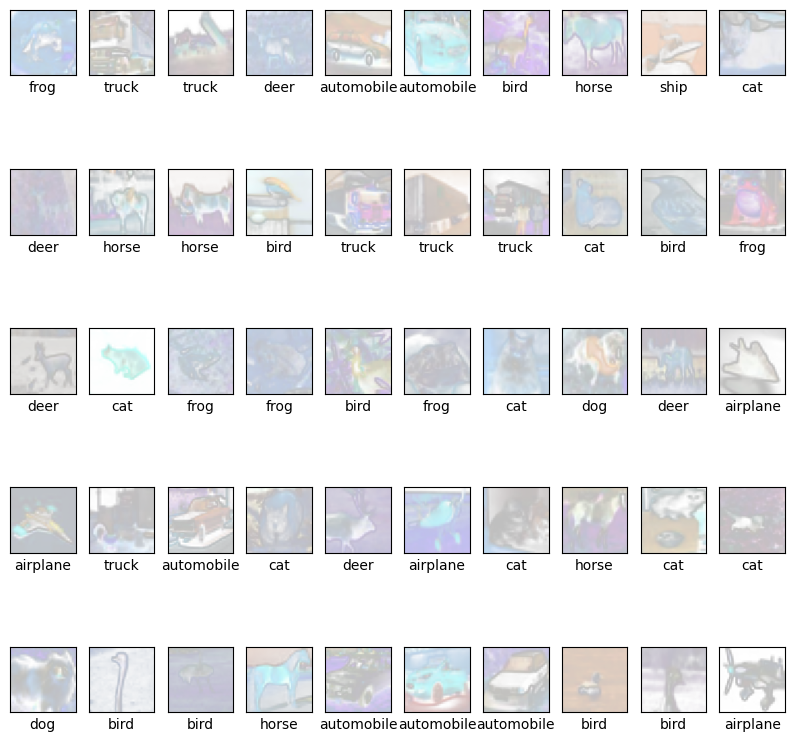

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [5]:
def build_model(hp):

    primary_filter_size = hp.Choice('filter_size',[3,4,5])
    secondary_filter_size = hp.Choice('secondary_filter_size',[3,4,5])
    tertiary_filter_size = hp.Choice('tertiary_filter_size',[3,4,5])

    model = models.Sequential()
    model.add(layers.Conv2D(32, 
                            (primary_filter_size, primary_filter_size),
                            activation=hp.Choice('layer_1_activation',['relu','tanh']), 
                            input_shape=(32, 32, 4)))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Conv2D(64, 
                            (secondary_filter_size, secondary_filter_size), 
                            activation=hp.Choice('layer_2_activation',['relu','tanh'])))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, 
                            (tertiary_filter_size, tertiary_filter_size), 
                            activation=hp.Choice('layer_3_activation',['relu','tanh'])))
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_1_units', min_value=32, max_value=256, step=32),
                           activation=hp.Choice('dense_1_activation',['relu','tanh'])))
    model.add(layers.Dense(10))
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    print("Model to be built:")
    print(model.summary())

    return model


Let's display the architecture of your model so far:

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

Here's the complete architecture of your model:

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [6]:
tuner = keras_tuner.tuners.RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=100,
    directory='cymk',
)

tuner.search(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

tuner.results_summary()

# test_loss, test_acc = best_model.evaluate(test_images,  test_labels, verbose=2)

# print(best_model.summary())
# print(test_acc)


Reloading Tuner from cymk/untitled_project/tuner0.json
Results summary
Results in cymk/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 078 summary
Hyperparameters:
filter_size: 3
secondary_filter_size: 4
tertiary_filter_size: 5
layer_1_activation: relu
layer_2_activation: relu
layer_3_activation: relu
dense_1_units: 32
dense_1_activation: tanh
Score: 0.7020999789237976

Trial 036 summary
Hyperparameters:
filter_size: 3
secondary_filter_size: 3
tertiary_filter_size: 4
layer_1_activation: tanh
layer_2_activation: relu
layer_3_activation: tanh
dense_1_units: 128
dense_1_activation: relu
Score: 0.7006000280380249

Trial 076 summary
Hyperparameters:
filter_size: 3
secondary_filter_size: 3
tertiary_filter_size: 3
layer_1_activation: tanh
layer_2_activation: relu
layer_3_activation: relu
dense_1_units: 224
dense_1_activation: tanh
Score: 0.7003999948501587

Trial 097 summary
Hyperparameters:
filter_size: 4
secondary_filter_size: 3
tertiary_filter

2024-10-11 05:10:37.095517: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Ultra
2024-10-11 05:10:37.095538: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2024-10-11 05:10:37.095545: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
2024-10-11 05:10:37.095558: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-11 05:10:37.095570: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
